In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
merged_data = pd.read_csv('merged_term_data_reduced.csv')

In [11]:
def prepare_data(df, drop_columns, categorical_columns, target_column='y', test_size=0.2, random_state=42):
    # Select columns to keep
    selected_columns = [col for col in df.columns if col not in drop_columns]
    df_selected = df[selected_columns]
    
    # Create dummy variables for categorical features
    df_dummies = pd.get_dummies(df_selected, columns=categorical_columns, drop_first=True)
    
    # Split into features and target
    X = df_dummies.drop(target_column, axis=1)
    y = df_dummies[target_column]
    
    # Create train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [12]:
drop_columns = ['age', 'day', 'default']
categorical_columns = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month']
X_train, X_test, y_train, y_test = prepare_data(merged_data, drop_columns, categorical_columns)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("Training label distribution:\n", y_train.value_counts(normalize=True))
print("Test label distribution:\n", y_test.value_counts(normalize=True))

Training set size: 47492
Test set size: 11874
Training label distribution:
 y
0    0.500526
1    0.499474
Name: proportion, dtype: float64
Test label distribution:
 y
1    0.502105
0    0.497895
Name: proportion, dtype: float64


In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df.head()

,balance,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,0.022995,-0.475949,0.966769,-0.722924,2.630706,-0.273132,-0.367577,-0.210222,-0.138353,-0.237806,...,-0.347232,-0.010261,-0.226882,-0.129052,-0.382191,-0.315847,-0.103878,-0.637838,-0.257955,-0.050749
1,-0.393877,-0.370736,-0.457617,-0.722924,-0.380126,-0.273132,2.720515,-0.210222,-0.138353,-0.237806,...,-0.347232,-0.010261,-0.226882,-0.129052,2.616491,-0.315847,-0.103878,-0.637838,-0.257955,-0.050749
2,-0.090902,-0.027304,0.125086,1.383272,-0.380126,-0.273132,-0.367577,-0.210222,-0.138353,-0.237806,...,-0.347232,-0.010261,-0.226882,-0.129052,-0.382191,-0.315847,-0.103878,-0.637838,-0.257955,-0.050749
3,-0.502146,-0.656598,-0.587107,-0.722924,-0.380126,-0.273132,2.720515,-0.210222,-0.138353,-0.237806,...,2.879919,-0.010261,-0.226882,-0.129052,-0.382191,-0.315847,-0.103878,-0.637838,-0.257955,-0.050749
4,-0.526906,-0.938490,-0.651851,-0.722924,-0.380126,-0.273132,-0.367577,-0.210222,-0.138353,-0.237806,...,-0.347232,-0.010261,-0.226882,-0.129052,-0.382191,3.166092,-0.103878,-0.637838,-0.257955,-0.050749


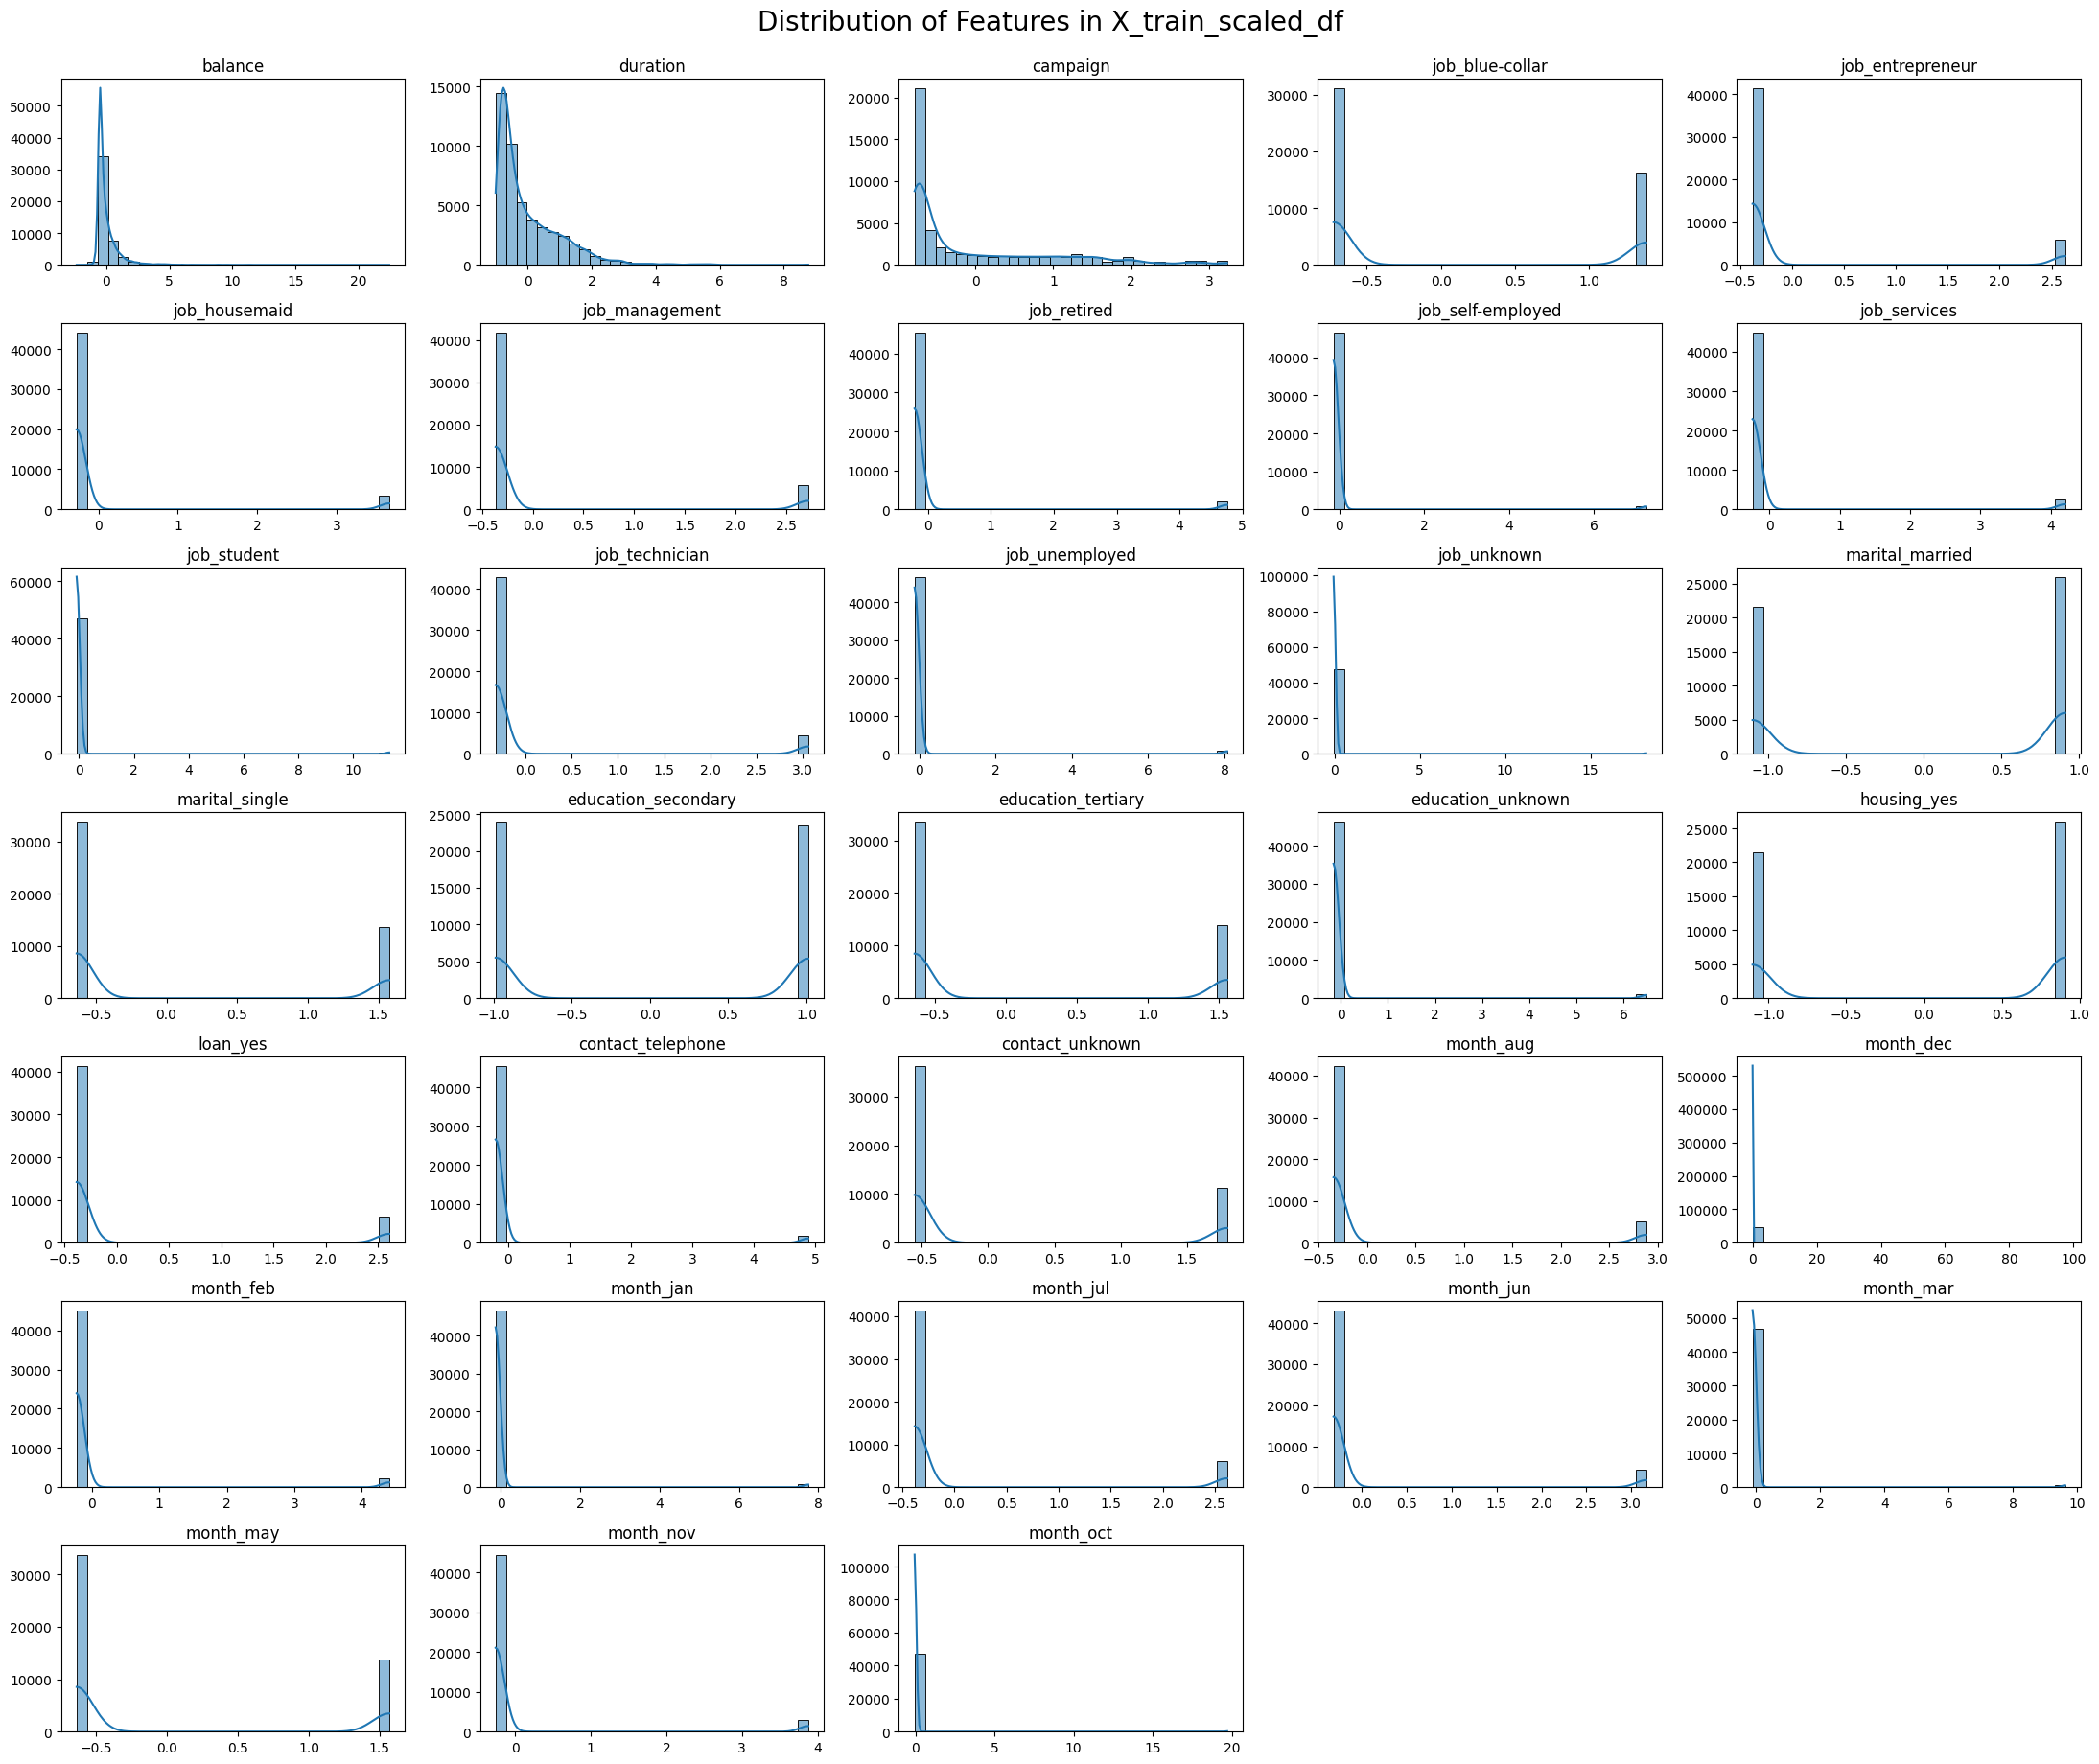

In [15]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(22, 18))
axes = axes.flatten()

for idx, col in enumerate(X_train_scaled_df.columns):
    ax = axes[idx]
    sns.histplot(X_train_scaled_df[col], bins=30, kde=True, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove any unused subplots
for j in range(len(X_train_scaled_df.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Distribution of Features in X_train_scaled_df', fontsize=20, y=1.02)
plt.show()

We find that month_dec has only one value in the entire training_data. This can create problems in convergence for logistic regression. So, month_dec should be dropped from both the training and test_datasets.

Text(0.5, 1.0, 'Distribution of Month Dec in Training Set')

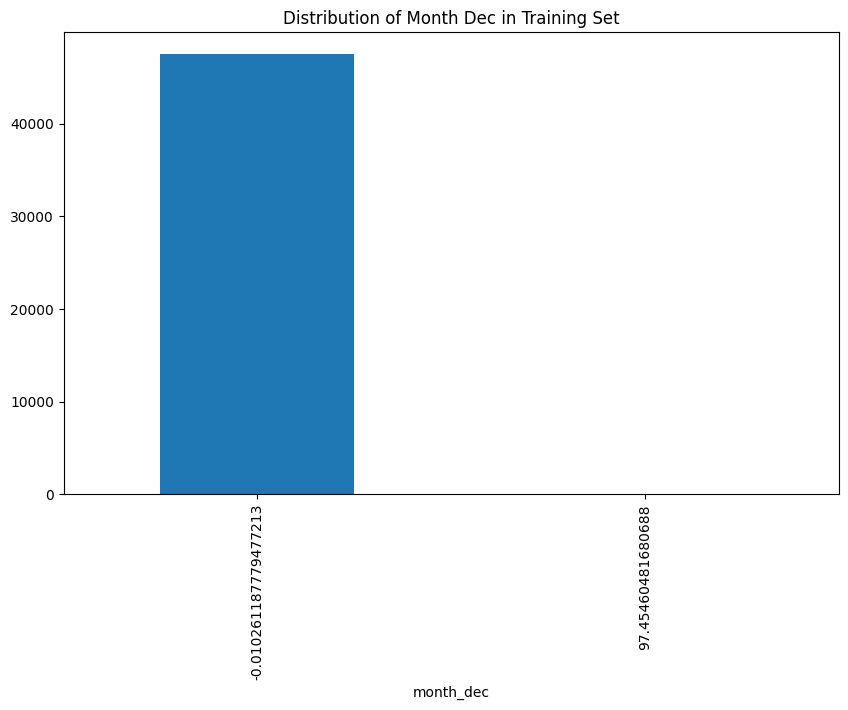

In [16]:
X_train_scaled_df['month_dec'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Month Dec in Training Set')

In [17]:
import numpy as np

# Drop 'month_dec' from X_train, X_test, X_train_scaled_df, and update X_train_scaled, X_test_scaled accordingly

# Drop from DataFrames
X_train = X_train.drop(columns=['month_dec'])
X_test = X_test.drop(columns=['month_dec'])
X_train_scaled_df = X_train_scaled_df.drop(columns=['month_dec'])

# Find the index of 'month_dec' in the scaled arrays
month_dec_idx = list(X_train_scaled_df.columns).index('month_dec') if 'month_dec' in X_train_scaled_df.columns else 24  # fallback to previous index if needed

# Drop from scaled arrays
X_train_scaled = np.delete(X_train_scaled, month_dec_idx, axis=1)
X_test_scaled = np.delete(X_test_scaled, month_dec_idx, axis=1)

In [18]:
import statsmodels.api as sm

# Add constant for intercept
X_train_sm = sm.add_constant(X_train_scaled)

# Fit logistic regression model
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Display model summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.167974
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                47492
Model:                          Logit   Df Residuals:                    47459
Method:                           MLE   Df Model:                           32
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.7577
Time:                        21:31:15   Log-Likelihood:                -7977.4
converged:                       True   LL-Null:                       -32919.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9444      0.043     45.256      0.000       1.860       2.029
x1             0.4418      0.

In [19]:
features = X_train_scaled_df.columns
# Create a list of variable names as they appear in the summary table
logit_summary_variables = ['const'] + list(features)

# Display the mapping
for idx, var in enumerate(logit_summary_variables):
    print(f"x{idx}: {var}")

x0: const
x1: balance
x2: duration
x3: campaign
x4: job_blue-collar
x5: job_entrepreneur
x6: job_housemaid
x7: job_management
x8: job_retired
x9: job_self-employed
x10: job_services
x11: job_student
x12: job_technician
x13: job_unemployed
x14: job_unknown
x15: marital_married
x16: marital_single
x17: education_secondary
x18: education_tertiary
x19: education_unknown
x20: housing_yes
x21: loan_yes
x22: contact_telephone
x23: contact_unknown
x24: month_aug
x25: month_feb
x26: month_jan
x27: month_jul
x28: month_jun
x29: month_mar
x30: month_may
x31: month_nov
x32: month_oct


ROC AUC Score: 0.9838


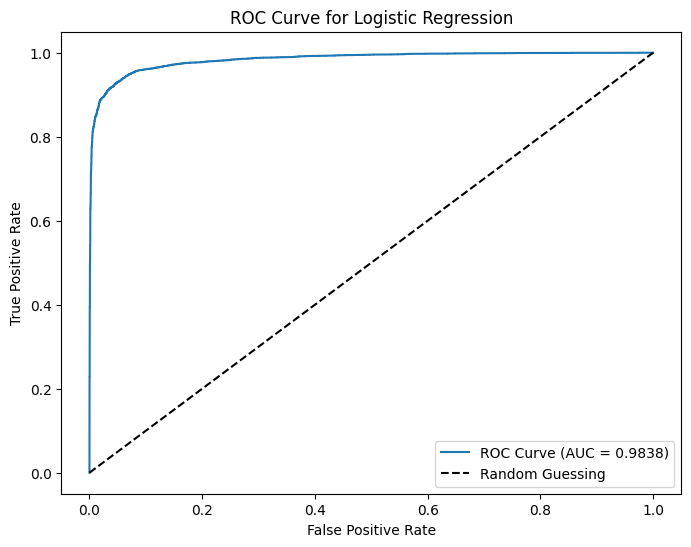

In [20]:
log_predictions = result.predict(sm.add_constant(X_test_scaled))
from sklearn.metrics import roc_auc_score, roc_curve
# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, log_predictions)    
print(f"ROC AUC Score: {roc_auc:.4f}")
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, log_predictions)
plt.figure(figsize=(8, 6))  
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()

In [21]:
accuracy = result.prsquared
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.7577


In [22]:
features = X_train_scaled_df.columns
logit_summary_variables = ['const'] + list(features)

# Display the mapping
for idx, var in enumerate(logit_summary_variables):
    print(f"x{idx}: {var}")

x0: const
x1: balance
x2: duration
x3: campaign
x4: job_blue-collar
x5: job_entrepreneur
x6: job_housemaid
x7: job_management
x8: job_retired
x9: job_self-employed
x10: job_services
x11: job_student
x12: job_technician
x13: job_unemployed
x14: job_unknown
x15: marital_married
x16: marital_single
x17: education_secondary
x18: education_tertiary
x19: education_unknown
x20: housing_yes
x21: loan_yes
x22: contact_telephone
x23: contact_unknown
x24: month_aug
x25: month_feb
x26: month_jan
x27: month_jul
x28: month_jun
x29: month_mar
x30: month_may
x31: month_nov
x32: month_oct


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.5, 0.75, 1.0]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)


NameError: name 'grid_search' is not defined

In [25]:

# Best estimator
best_rf = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

# Feature importances
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


Best parameters: {'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': None}
                Feature  Importance
2              campaign    0.472150
1              duration    0.274737
0               balance    0.099346
4      job_entrepreneur    0.016172
11       job_technician    0.013660
6        job_management    0.010937
22      contact_unknown    0.009592
3       job_blue-collar    0.008438
17   education_tertiary    0.007786
14      marital_married    0.007694
19          housing_yes    0.006474
26            month_jul    0.006454
23            month_aug    0.005714
16  education_secondary    0.005358
29            month_may    0.005327
20             loan_yes    0.004845
30            month_nov    0.004784
15       marital_single    0.004695
9          job_services    0.004551
5         job_housemaid    0.004301
27            month_jun    0.004170
21    contact_telephone    0.003327
28            month_mar    0.003106
24            month_feb    0.00290

Accuracy on validation set: 0.9405


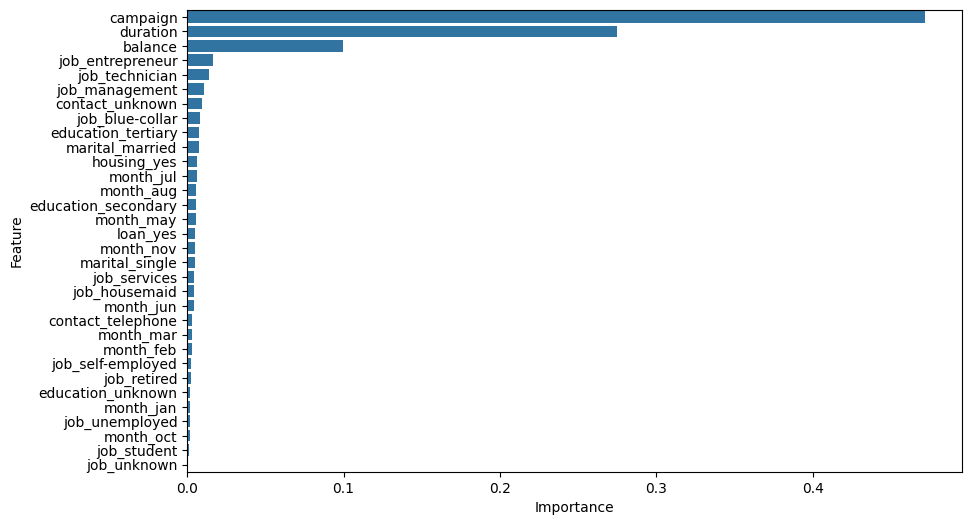

In [26]:
print(f"Accuracy on validation set: {best_rf.score(X_test_scaled, y_test):.4f}")

import matplotlib.pyplot as plt
import seaborn as sns
#Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df
)

plt.show()

Best parameters: {'subsample': 0.75, 'n_estimators': 500, 'max_depth': None, 'gamma': 0.1, 'eta': 0.2, 'colsample_bytree': 0.5}
Number of features: 32
Number of examples: 47492
                Feature  Importance
2              campaign    0.137597
1              duration    0.068657
4      job_entrepreneur    0.066690
5         job_housemaid    0.054147
11       job_technician    0.051564
6        job_management    0.044619
25            month_jan    0.044018
22      contact_unknown    0.040516
30            month_nov    0.037332
3       job_blue-collar    0.036460
28            month_mar    0.033021
31            month_oct    0.032636
23            month_aug    0.030228
8     job_self-employed    0.028550
26            month_jul    0.026586
7           job_retired    0.023919
12       job_unemployed    0.022436
9          job_services    0.021696
0               balance    0.021184
14      marital_married    0.020639
27            month_jun    0.019680
21    contact_telephone    0.01

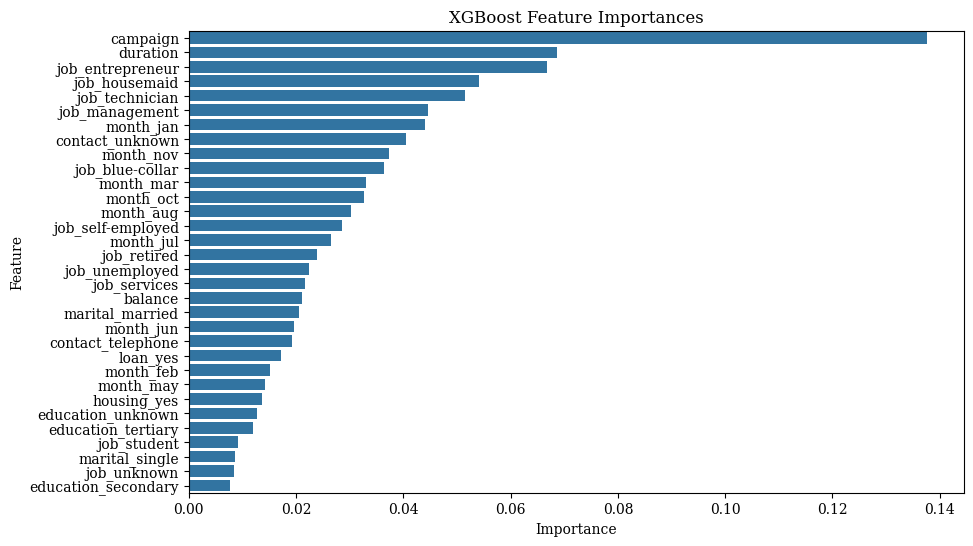

In [51]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'gamma': [0, 0.1, 0.2, 0.5, 1],
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'max_depth': [3, 5, 7, None],
    'subsample': [0.5, 0.75, 1.0]
}


xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    scoring='recall',
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

best_xgb = random_search.best_estimator_
test_score = best_xgb.score(X_test_scaled, y_test)

# Feature importance
xgb_importances = best_xgb.feature_importances_
xgb_feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

print("Best parameters:", random_search.best_params_)
print("Number of features:", X_train.shape[1])
print("Number of examples:", X_train.shape[0])
print(xgb_feature_importance_df)
print(f"Test set recall: {test_score:.4f}")


plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=xgb_feature_importance_df
)
plt.title('XGBoost Feature Importances')
plt.show()

In [53]:
reduced_features = xgb_feature_importance_df[xgb_feature_importance_df['Importance'] > 0.01]['Feature'].tolist()
print("Reduced feature set:", reduced_features)

# Select only the reduced features from the scaled DataFrames
x_train_reduced_scaled = X_train_scaled_df[reduced_features]
x_test_reduced_scaled = pd.DataFrame(X_test_scaled, columns=features)[reduced_features]

# Fit the best_xgb model on the reduced training data
best_xgb_reduced = best_xgb
best_xgb_reduced.fit(x_train_reduced_scaled, y_train)

# Evaluate accuracy on the reduced test data
reduced_test_accuracy = best_xgb_reduced.score(x_test_reduced_scaled, y_test)
print(f"Recall on reduced test set: {reduced_test_accuracy:.4f}")

Reduced feature set: ['campaign', 'duration', 'job_entrepreneur', 'job_housemaid', 'job_technician', 'job_management', 'month_jan', 'contact_unknown', 'month_nov', 'job_blue-collar', 'month_mar', 'month_oct', 'month_aug', 'job_self-employed', 'month_jul', 'job_retired', 'job_unemployed', 'job_services', 'balance', 'marital_married', 'month_jun', 'contact_telephone', 'loan_yes', 'month_feb', 'month_may', 'housing_yes', 'education_unknown', 'education_tertiary']
Recall on reduced test set: 0.9455


In [33]:
%pip install optuna==3.5.0 --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')

import optuna
from xgboost import XGBClassifier
from sklearn.metrics import recall_score

# Define feature combinations
feature_combos = {
    'All features': features.tolist(),
    'Reduced features': reduced_features,
    'Smaller combo': ['campaign', 'duration','job_entrepreneur', 'job_technician', 'contact_unknown', 'job_management']
}

optuna_results = {}

for combo_name, feats in feature_combos.items():
    def objective(trial):
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'gamma': trial.suggest_float('gamma', 0, 1.0),
            'max_depth': trial.suggest_int('max_depth', 2, 8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'eval_metric': 'logloss',
            'random_state': 42
        }
        # Scale features
        X_train_fs = scaler.fit_transform(X_train[feats])
        X_test_fs = scaler.transform(X_test[feats])
        model = XGBClassifier(**params)
        model.fit(X_train_fs, y_train)
        preds = model.predict(X_test_fs)
        return recall_score(y_test, preds)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30, show_progress_bar=False)
    best_params = study.best_params
    best_score = study.best_value

    # Train best model for reporting
    X_train_fs = scaler.fit_transform(X_train[feats])
    X_test_fs = scaler.transform(X_test[feats])
    best_model = XGBClassifier(
        **{**best_params, 'eval_metric': 'logloss', 'random_state': 42}
    )
    best_model.fit(X_train_fs, y_train)
    val_score = recall_score(y_test, best_model.predict(X_test_fs))

    optuna_results[combo_name] = {
        'best_params': best_params,
        'validation_score': val_score,
        'model': best_model
    }
    print(f"Feature combo: {combo_name}")
    print(f"Best params: {best_params}")
    print(f"Validation accuracy: {val_score:.4f}\n")

[I 2025-06-18 00:54:45,335] A new study created in memory with name: no-name-3425db24-9103-467b-9db5-23558bba0588
[I 2025-06-18 00:54:46,102] Trial 0 finished with value: 0.9243542435424354 and parameters: {'eta': 0.010760589783689331, 'n_estimators': 433, 'gamma': 0.256066791866559, 'max_depth': 6, 'colsample_bytree': 0.6124171595118479}. Best is trial 0 with value: 0.9243542435424354.
[I 2025-06-18 00:54:47,075] Trial 1 finished with value: 0.9263669909426367 and parameters: {'eta': 0.010422247453906361, 'n_estimators': 591, 'gamma': 0.19397089834279424, 'max_depth': 5, 'colsample_bytree': 0.7592448509803238}. Best is trial 1 with value: 0.9263669909426367.
[I 2025-06-18 00:54:48,132] Trial 2 finished with value: 0.933579335793358 and parameters: {'eta': 0.2981885329389588, 'n_estimators': 818, 'gamma': 0.028879277713608653, 'max_depth': 8, 'colsample_bytree': 0.9811027334229703}. Best is trial 2 with value: 0.933579335793358.
[I 2025-06-18 00:54:49,118] Trial 3 finished with value: 

Feature combo: All features
Best params: {'eta': 0.18741228399868998, 'n_estimators': 719, 'gamma': 0.9988115395939814, 'max_depth': 7, 'colsample_bytree': 0.5850091184173639}
Validation accuracy: 0.9386



[I 2025-06-18 00:55:08,711] Trial 0 finished with value: 0.9280442804428044 and parameters: {'eta': 0.02086464524080373, 'n_estimators': 227, 'gamma': 0.91799018551271, 'max_depth': 6, 'colsample_bytree': 0.5237060758463699}. Best is trial 0 with value: 0.9280442804428044.
[I 2025-06-18 00:55:09,533] Trial 1 finished with value: 0.9384434753438443 and parameters: {'eta': 0.17565844924151025, 'n_estimators': 517, 'gamma': 0.04608948854830064, 'max_depth': 4, 'colsample_bytree': 0.7463922170552254}. Best is trial 1 with value: 0.9384434753438443.
[I 2025-06-18 00:55:10,002] Trial 2 finished with value: 0.9334116068433411 and parameters: {'eta': 0.11193947202663553, 'n_estimators': 241, 'gamma': 0.3148277884657623, 'max_depth': 3, 'colsample_bytree': 0.8924564856028416}. Best is trial 1 with value: 0.9384434753438443.
[I 2025-06-18 00:55:10,340] Trial 3 finished with value: 0.9164709828916471 and parameters: {'eta': 0.017945175206670272, 'n_estimators': 72, 'gamma': 0.45176305028279706, '

Feature combo: Reduced features
Best params: {'eta': 0.059390162197440095, 'n_estimators': 756, 'gamma': 0.11861468517441826, 'max_depth': 4, 'colsample_bytree': 0.5693253507798903}
Validation accuracy: 0.9388



[I 2025-06-18 00:55:36,666] Trial 0 finished with value: 0.9042267695404227 and parameters: {'eta': 0.020913119388270895, 'n_estimators': 457, 'gamma': 0.878395335345449, 'max_depth': 7, 'colsample_bytree': 0.5970084894748788}. Best is trial 0 with value: 0.9042267695404227.
[I 2025-06-18 00:55:36,952] Trial 1 finished with value: 0.9052331432405233 and parameters: {'eta': 0.023313473844102407, 'n_estimators': 155, 'gamma': 0.8503565559355717, 'max_depth': 7, 'colsample_bytree': 0.954218195086258}. Best is trial 1 with value: 0.9052331432405233.
[I 2025-06-18 00:55:37,319] Trial 2 finished with value: 0.9057363300905736 and parameters: {'eta': 0.06363253830214696, 'n_estimators': 621, 'gamma': 0.6891698179602808, 'max_depth': 4, 'colsample_bytree': 0.5583290496365907}. Best is trial 2 with value: 0.9057363300905736.
[I 2025-06-18 00:55:37,668] Trial 3 finished with value: 0.9059040590405905 and parameters: {'eta': 0.0995940360160722, 'n_estimators': 712, 'gamma': 0.4703678381765576, 'm

Feature combo: Smaller combo
Best params: {'eta': 0.08121248858630731, 'n_estimators': 547, 'gamma': 0.7617916975344381, 'max_depth': 2, 'colsample_bytree': 0.7067463039788832}
Validation accuracy: 0.9072



              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5912
           1       0.95      0.94      0.95      5962

    accuracy                           0.95     11874
   macro avg       0.95      0.95      0.95     11874
weighted avg       0.95      0.95      0.95     11874



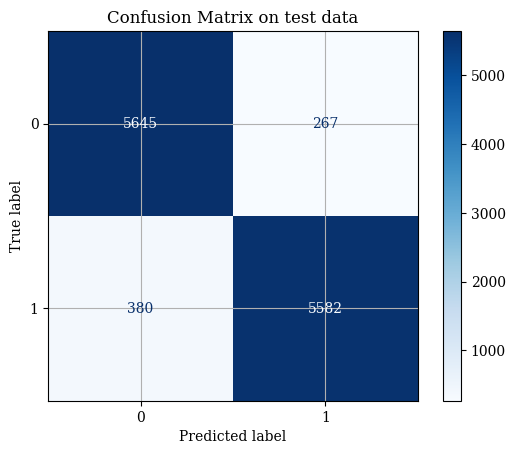

['xgb_model_new.pkl']

In [55]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
plt.rcParams['font.family'] = 'serif'

# Prepare the data
selected_feats = reduced_features  # Use the reduced features from the previous step
X_train_fs = scaler.fit_transform(X_train[selected_feats])
X_test_fs = scaler.transform(X_test[selected_feats])

# Train the XGBoost model with given parameters
xgb_model = best_xgb  # Use the best model from previous steps
# xgb_model.fit(X_train_fs, y_train)

# Predict on validation set
y_pred = xgb_model.predict(X_test_fs)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on test data")
plt.grid('off')
plt.show()

import joblib

# Save the trained XGBoost model to a .pkl file
joblib.dump(xgb_model, "xgb_model_new.pkl")

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load the test data
test_data = pd.read_csv('term_deposit_test_data.csv')

# Prepare the test data: create dummies, drop columns, align columns
test_data_selected = test_data[[col for col in test_data.columns if col not in drop_columns]]
test_data_dummies = pd.get_dummies(test_data_selected, columns=categorical_columns, drop_first=True)

test_data_dummies.head()

,balance,duration,campaign,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,0,111,1,0,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
1,519,72,1,0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2,639,358,2,0,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,535,369,2,0,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,177,187,4,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [57]:
test_input.columns

Index(['balance', 'duration', 'campaign', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct'],
      dtype='object')

In [58]:
X_train_scaled_df.columns

Index(['balance', 'duration', 'campaign', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown',
       'month_aug', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct'],
      dtype='object')

In [59]:
test_labels = test_data_dummies['y']
test_input = test_data_dummies.drop('y', axis=1)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      7421
           1       0.45      0.49      0.47       579

    accuracy                           0.92      8000
   macro avg       0.70      0.72      0.71      8000
weighted avg       0.92      0.92      0.92      8000



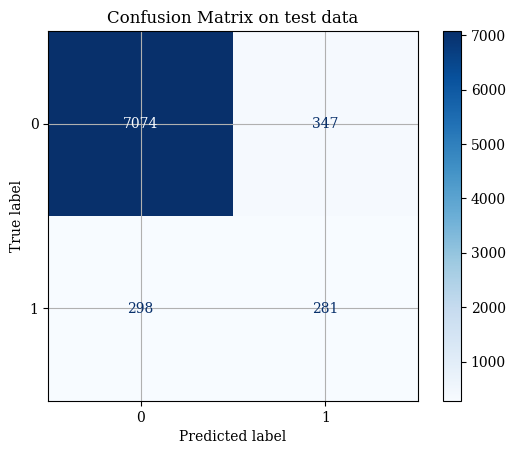

In [61]:
# Prepare the data

selected_feats = reduced_features  # Use the reduced features from the previous step
X_train_fs = scaler.fit_transform(X_train[selected_feats])
X_test_fs = scaler.transform(test_input[selected_feats])

# Train the XGBoost model with given parameters
xgb_model = best_xgb  # Use the best model from previous steps

# Predict on validation set
y_pred = xgb_model.predict(X_test_fs)

# Classification report
print(classification_report(test_labels, y_pred))

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on test data")
plt.grid('off')
plt.show()
